## Genetic Programming for Symbolic Regression
### Seminar 1 for the subject Intelligent Systems
*Authors: Edita Džubur, Ana Poklukar*

*December 3, 2023*

In the first seminar, the primary objective was to utilize genetic algorithms for evolving symbolic expressions (mathematical equations) to fit various sets of input-output pairs best.


Our job was to develop a function that processes the 2D representation of a dataset and yields the
optimal symbolic expression, as derived by the genetic algorithm. The primary
steps involved:
- Converting the dataset into an appropriate format.
- Deciding on an effective solution representation.
- Designing a fitness function.
- Implementing and executing the genetic algorithm.


In [27]:
import pandas as pd
import numpy as np
import math
import sys
import time
import matplotlib.pyplot as plt

data = pd.read_csv('./dataset.csv', sep=',')

### Tree data structure

We wrote a data structure to parse the data into the expression trees. We designed a class `Node` that represents nodes in a tree. Each node has data, left and right child nodes and a flag indicating whether it's a leaf. The `__str__` method is implemented to print the equation represented by the tree.

In [50]:
class Node:
    def __init__(self, data, left, right, is_leaf):
        self.is_leaf = is_leaf
        self.data = data
        self.left = left
        self.right = right

    def __str__(self):
        if self.is_leaf:
            return str(self.data)
        if self.data == "sin" or self.data == "cos" or self.data == "tan" or self.data == "log":
            return self.data + "(" + str(self.left) + ")"
        else:
            return "(" + str(self.left) + str(self.data) + str(self.right) + ")"

The `copy_node` function creates a deep copy of a given tree node. If the node is a leaf, a new leaf with the same data is created. If the node is not a leaf, a new node is created with the same data, and the left and right children are recursively copied.

In [3]:
def copy_node(node: Node):
    """Create deep copy of tree."""
    if node.is_leaf:
        return Node(node.data, None, None, True)
    else:
        return Node(node.data, copy_node(node.left), copy_node(node.right), False)

We define the list of operators, that can be present in the expression. The first list contains the basic operators, which were present in the test data set, while the second list contains operators, introduced later for the diversity in our genetic algorithm.

In [4]:
operators1 = ["+", "-", "*", "/", "**"]
operators2 = ["sin", "cos", "tan", "log"]

The `evaluate_node` function walks over the equation tree and evaluates it. If the node is a leaf, it returns the variable `x` or an integer value, otherwise if the node is an operator, it recursively evaluates the left and right children based on the operator.

The function also includes some additional checks to handle special cases, such as division by zero, negative exponents and logarithm of non-pozitive values.

In [62]:
def evaluate_node(node: Node, x: float):
    """Walk over equation tree and evaluate it. 
    Leaves can either be integers or variable x.
    """
    if node.is_leaf:
        if node.data == "x":
            return x
        
        else:
            return node.data
    else:
        if node.data == "+":
            return evaluate_node(node.left, x) + evaluate_node(node.right, x)
        elif node.data == "-":
            return evaluate_node(node.left, x) - evaluate_node(node.right, x)
        elif node.data == "*":
            return evaluate_node(node.left, x) * evaluate_node(node.right, x)
        elif node.data == "/":
            if(evaluate_node(node.right, x) == 0):
                return 0
            return evaluate_node(node.left, x) / evaluate_node(node.right, x)
        elif node.data == "**":
            if(evaluate_node(node.right,x) < 0):
                return 0 
            return evaluate_node(node.left, x) ** evaluate_node(node.right, x)
        elif node.data == "sin":
            return np.sin(evaluate_node(node.left, x))
        elif node.data == "cos":
            return np.cos(evaluate_node(node.left, x))
        elif node.data == "tan":
            return np.tan(evaluate_node(node.left, x))
        elif node.data == "log":
            if(evaluate_node(node.left, x) <= 0):
                return 0
            return np.log2(evaluate_node(node.left, x))
        else:
            raise ValueError("Unknown operator: " + node.data)

The `evaluate_node` function walks over the equation tree and evaluates it. If the node is a leaf, it returns the variable `x` or an integer value, otherwise if the node is an operator, it recursively evaluates the left and right children based on the operator.

In [6]:
def tree_size(node: Node):
    """Return the size of the tree."""
    if node == None:
        return 0
    if node.is_leaf:
        return 1
    else:
        return tree_size(node.left) + tree_size(node.right) + 1

### Population generating
To execute the genetic algorithm, we defined a function `create_initial_population` that aims to generate an initial population of nodes for representing simple mathematical equations.

Firstly, we initialize an empty list to store the nodes representing equations and a boolean `is_x` that tracks whether the next node will represent the variable `x` or numeric value. The function iterates `pop_size` times to create the desired population size. For each iteration it randomly decides whether the next node should represent the variable `x`(with a probability 25%) or a numeric value. If `is_x` is `True`, a new node representing the variable `x` is created, if `False`, a new node representing a randomly chosen integer from the range [-10,10] is created. The created node is then appended to the `initial_population` list. The function returns the populated list of nodes, constituting the initial population.

In [7]:
variables_in_initial_population = [True, False, False, False]

def create_initial_population(pop_size):
    initial_population = []
    is_x = False
    for _ in range(pop_size):
        is_x = np.random.choice(variables_in_initial_population)
        if is_x:
            new_node = Node("x", None, None, True)
        else:
            nr = np.random.randint(-10,10)
            if nr == 0:
                nr = np.random.randint(1,10)
            new_node = Node(nr, None, None, True)
        initial_population.append(new_node)
    return initial_population

### Crossover function
The function `custom_crossover` is designed to perform crossover between two nodes `node1` and `node2`.

An operator is randomly chosen from the list of operators, then a new node is created as the root of the offspring tree. This node has the selected operator and its left and right children are copies of nodes from the two parent trees `node1` and `node2`. The last argument False passed to the Node constructor indicates that the node is not a leaf. The function returns the newly created offspring tree.

In [77]:
p = 1

def custom_crossover(node1: Node, node2: Node):
    if np.random.uniform(0,1) < p:
        operator = np.random.choice(operators1)
    else:
        operator = np.random.choice(operators2)
        
    root_node = Node(operator, copy_node(node1), copy_node(node2), False)
    return root_node

### Mutation function

The function `custom_mutation` is designed to perform mutation on a tree structure by introducing random changes to the nodes with a specified probability.

We defined the mutation probability as some percentage. The function checks whether a randomly generated number is less than the mutation probability. If so, it performs mutation. If the node is a leaf, it randomly decides whether to mutate the leaf node to represent the variable `x` or a random numeric value. If the node is not a leaf, the node's data is set to a randomly chosen operator. Then, if the node is not a leaf, the mutation operation is recursively applied to its left and right children. The mutated tree is returned as the result of the mutation operation.

In [9]:
mutation_rate = 0.3

In [41]:
prob_op = 1

def custom_mutation(node: Node):
    if np.random.uniform() < mutation_rate:
        if node.is_leaf:
            is_x = np.random.choice([True, True, False, False])
            if is_x:
                node.data = "x"
            else:
                node.data = np.random.randint(-10, 10)
                if node.data == 0:
                    node.data = np.random.randint(1, 10)
        else:
                
                if np.random.uniform() < prob_op:
                        node.data = np.random.choice(operators1)
                else:
                    node.data = np.random.choice(operators2)
    
    if not node.is_leaf:
        custom_mutation(node.left)
        custom_mutation(node.right)
    return node

### Fitness function

We designed the fitness function `fitness_function` which evaluates the fitness of a potential solution within a genetic algorithm for symbolic regression.

It iterates through the dataset, where `x_values` represent input values and `y_values`represent corresponding true output values and evaluates the current solution (tree) for each input value, obtaining the predicted output values. Then, the sum of absolute errors between predicted and true output values is being computed, normalised by the number of data points, this quantifies the overall fitness of the solution.

Before returning the fitness score, the size of the tree is determined using the `tree_size` function. The final fitness score is then defined as a combination of `negative squared errors` (because our genetic algorithm maximizes fitness) and a penalty term for large tree sizes. The penalty term is scaled by a factor of `penalty_factor`.

If an `OverflowError` occurs during evaluation, the function returns the negative maximum integer value, effectively assigning a low fitness to the solution.

The function also checks for `NaN` values, the function will then also return the negative maximum integer value. This is a penalty for cases where the solution results in invalid computations.

If the `squares_errors` are zero (indicating a perfect fit to the data), the function returns a fitness of 0 and is not penalized by the tree size. That is because we cannot set a proportional `penalty_factor` which would be fit for all different datasets. We could have a solution which would have a close-to-zero MSE but a smaller treesize than the correct solution (where MSE = 0), and be assigned a higher (better) fitness than the correct solution, which we want to avoid. 

In [11]:
def fitness_function(x_values, y_values, ga_instance, solution: Node, solution_idx):
    squared_errors = 0
    for x, y_true in zip(x_values, y_values):
        try:
            y_pred = evaluate_node(solution, x)
            squared_errors += (abs(y_true - y_pred))/len(x_values)
        except OverflowError:
            return -sys.maxsize


    treesize = tree_size(solution)
    if (math.isnan(squared_errors) or math.isnan(treesize)):
        return -sys.maxsize
    
    penalty_factor = 10
    
    if(squared_errors == 0):
        return 0
    return -squared_errors - treesize * penalty_factor  # penalize large trees

### Selection function

The function `selection` performs the selection of individuals (parents) from the current population proportionaly based on their fitness scores. This type of selection is called `fitness proportionate selection`, also known as `roulette wheel selection`. 

As in all selection methods, the fitness function assigns a fitness to possible solutions in the population. This fitness level is used to associate a probability of selection with each individual solution. If f(i) is the fitness of individual i in the population, its probability of being selected is $p_i = \frac{f_i}{\sum_{j=1}^{N} f_j} \$, where `N` is the number of individuals in the population. This way there is still a chance for solutions with a weaker fitness to not be eliminated, which ensures diversity in the population.

Our code firstly converts the negative fitness scores to positive values, so now we want a smaller positive fitness value to have a higher probability weight. That is why the weights calculated with the formula above are then inverted and normalised again, to sum up to 1. The parents are then randomly selected from the population based on the calculated probabilities and converted into a list. The function returns a list of deep copies of the selected parents.

In [12]:
def selection(population, fitness_scores, num_parents):
    parents = []
    fitness_weights = -fitness_scores
    fitness_weights = 1/(fitness_weights+1e-6)
    fitness_weights = fitness_weights / fitness_weights.sum()
    parents = np.random.choice(population, num_parents, p=fitness_weights)
    parents = parents.tolist()
    return [copy_node(parent) for parent in parents]

### Sort function
The function `sort` is a sorting function for a population of individuals based on their fitness scores. It recieves an array representing a population of individuals and an array representing the fitness scores of each individual in the population.

Firstly, we sort the fitness scores in descending order. The `fitness_scores` and `population` arrays are then reordered and returned based on the sorted indices.

In [13]:
def sort(population, fitness_scores):
        sorted_ixs = np.argsort(fitness_scores)[::-1]
        fitness_scores = fitness_scores[sorted_ixs]
        population = population[sorted_ixs]
        return population, fitness_scores

### Executing the genetic algorithm

The `genetic_algorithm` recieves as input parameters:
- `x_values`: A list of input values.
- `y_values`: The corresponding list of true output values.
- `num_generations`: The number of generations (iterations) for the genetic algorithm to run.
- `population`: An initial population of solutions, where each solution is represented as a tree or some other data structure.
- `elite_size`: The number of top individuals (elites) to be preserved from one generation to the next.
- `num_children`: The number of offspring to be generated through crossover in each generation.
- `num_rest`: The number of individuals to be selected for the next generation through selection.

The function iterates over a specified number of generations. For each solution in the current population, the fitness function is evaluated using the `fitness_function`. The fitness scores are stored in `fitness_scores` list.

The `sort` function is used to sort the population based on the fitness scores in descending order. The sorted population and fitness scores are then updated. The top `elite_size` individuals are selected from the sorted population and stored in the `elites` list. The remaining individuals after elites are selected, along with their corresponding fitness scores. Offspring are generated through crossover. Parents are selected using the `selection` function and then crossed over using `custom_crossover` function. The next generation's population is created by selecting individuals for the next generation through a form of selection and adding the generated children. Mutation is applied to each individual in the population using the `custom_mutation` function. The elites from the previous generation are added to the current population.

After the specified number of generations, the function returns the final population.

In [14]:

def genetic_algorithm(x_values, y_values,num_generations, population, elite_size, num_children, num_rest):
    for generation in range(num_generations):
        fitness_scores = []
        for solution in population:
            score = fitness_function(x_values, y_values, None, solution, None)
            fitness_scores.append(score)
                
        population, fitness_scores = sort(np.array(population), np.array(fitness_scores))
        if(fitness_scores[0] == 0):
            return population
        
        print("Population", [str(x) for x in population])
        print("Fitness scores", fitness_scores)

        elites = population[:elite_size].tolist()

        rest_of_population = population[elite_size:]
        rest_of_population_scores = fitness_scores[elite_size:]

        children = []
        for i in range(num_children):
            parent_1 = selection(rest_of_population, rest_of_population_scores, 1)[0]
            parent_2 = selection(rest_of_population, rest_of_population_scores, 1)[0]
            children.append(custom_crossover(parent_1, parent_2))

        population = selection(rest_of_population, rest_of_population_scores, num_rest) + children


        for child in population:
            custom_mutation(child)

        population = population + elites
    return population


Then we executed the algorithm on some data.

Firstly, we initialised the parameters needed for `genetic_algorithm`. Then, a loop is made to iterate over a specific range of examples in the test dataset.

The `create_intial_population` function is called to generate an initial population of individuals. The size of the population is determined by `population_size`.

The `x_values` and `y_values` are loaded from dataset. The `eval` function is used to evaluate the string representations of these values as python expressions. The `solution` is the true equation or expression corresponding to the dataset.

We execute the algorithm three times, to increase the chances of finding a good solution. `genetic_algorithm` is called with the specified parameters, resulting population is then stored in `result_pop`. Fitness scores for each individual in the final population are computed using the `fitness_function`. The fitness function is sorted based on fitness scores. If the current minimum fitness is `None` or smaller than the best fitness in the current run, the minimum fitness and the corresponding best solution are updated.

In [39]:
population_size = 20
num_children = population_size // 3
num_rest = population_size // 2
elite_size = population_size - num_children - num_rest 
num_generations = 10

for i in range(3,4):
    initial_population = create_initial_population(population_size)
    x_values = eval(data["Xs"][i])
    y_values = eval(data["Ys"][i])
    solution = data["Equation"][i]
    min_fitness = None

    for j in range(3):
        result_pop = genetic_algorithm(x_values, y_values, num_generations, initial_population, elite_size, num_children, num_rest)
        fitness_scores = []
        for k in result_pop:
            fitness_scores.append(fitness_function(x_values, y_values, None, k, None))
        result_pop, fitness_scores = sort(np.array(result_pop), np.array(fitness_scores))
        if min_fitness == None or min_fitness < fitness_scores[0]:
            min_fitness = fitness_scores[0]
            best_solution = str(result_pop[0])

    print("Real solution", solution, "------ Best solution", best_solution, "Solution fitness" , min_fitness, "Tree size", tree_size(result_pop[0]))

Population ['x', 'x', 'x', 'x', 'x', 'x', '9', '7', '7', '5', '5', '4', '2', '1', '-3', '-4', '-5', '-6', '-9', '-10']
Fitness scores [-212.   -212.   -212.   -212.   -212.   -212.   -253.58 -255.54 -255.54
 -257.5  -257.5  -258.5  -260.5  -261.5  -265.5  -266.5  -267.5  -268.5
 -271.5  -272.5 ]
Population ['(x+x)', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '(x--9)', '(-9*-4)', '5', '5', '2', '1', '-3', '(6/5)', '(-7/-6)', '(2+-9)']
Fitness scores [-181.5        -212.         -212.         -212.         -212.
 -212.         -212.         -212.         -212.         -212.
 -223.12       -248.74       -257.5        -257.5        -260.5
 -261.5        -265.5        -281.3        -281.33333333 -289.5       ]
Population ['(x+x)', '(x+x)', '((x-4)+x)', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '(x--9)', '(-9+x)', '-3', '(-5--9)', '(x-x)', '(x**(2/-1))', '(x-(-9*x))', '((-2--9)/(x-6))', '(x*-9)', '(-9*x)']
Fitness scores [-181.5        -181.5        -205.5        -212.         -212.
 -212.       

### Introducing diversity
To introduce some diversity in the types of equations and operators the genetic algorithm can evolve, we have already defined a list of new operators (sin, cos, tan, log).

We tested the robustness and versatility of our algorithm by defining our own dataset and the equation we are looking for is `3*sin(x)`.

We change the probability for operators to 50%.

In [108]:
prob_op = 0.5
p = 0.5
operators1 = ["+", "-", "*", "/"]

Ys = []
Xs = []
for x in range(1,100):
    Xs.append(x)
    Ys.append(3*np.sin(x))

  
initial_population = create_initial_population(population_size)
min_fitness = None
for j in range(10):
        result_pop = genetic_algorithm(Xs, Ys, num_generations, initial_population, elite_size, num_children, num_rest)
        fitness_scores = []
        for k in result_pop:
            fitness_scores.append(fitness_function(Xs, Ys, None, k, None))
        result_pop, fitness_scores = sort(np.array(result_pop), np.array(fitness_scores))
        if min_fitness == None or min_fitness < fitness_scores[0]:
            min_fitness = fitness_scores[0]
            best_solution = str(result_pop[0])

print("3*sinx", "------ Best solution", best_solution, "Solution fitness" , min_fitness)

Population ['-1', '2', '-2', '-2', '5', '5', '-5', '6', '6', '-6', '7', '-7', '-8', '9', '-10', '-10', 'x', 'x', 'x', 'x']
Fitness scores [-12.03484699 -12.34634571 -12.36804958 -12.36804958 -14.98850925
 -14.98850925 -15.01149075 -15.98850925 -15.98850925 -16.01149075
 -16.98850925 -17.01149075 -18.01149075 -18.98850925 -20.01149075
 -20.01149075 -60.03401037 -60.03401037 -60.03401037 -60.03401037]
Population ['-1', '2', '-2', '-2', '-4', '5', '6', '-6', '-6', '-6', 'sin(-10)', 'tan(-10)', 'cos(9)', '(9/9)', '(-7/-6)', 'log(5)', 'x', 'x', 'x', 'x']
Fitness scores [-12.03484699 -12.34634571 -12.36804958 -12.36804958 -14.01149075
 -14.98850925 -15.98850925 -16.01149075 -16.01149075 -16.01149075
 -31.95008086 -31.97128364 -32.01426718 -32.02201789 -32.05793392
 -32.50938046 -60.03401037 -60.03401037 -60.03401037 -60.03401037]
Population ['-1', '2', '-2', '-2', '5', '-6', 'sin(x)', '(1/x)', 'cos(5)', 'cos(9)', '(9/9)', 'log(5)', 'log(cos(1))', 'tan(x)', 'x', 'x', 'x', 'x', '((x/6)-x)', '(

### Comparing performance under different configurations

#### Changing the mutation rate
Modifying the mutation rate is a critical parameter adjustment in genetic algorithms that can significantly influence the algorithm's exploration and exploitation capabilities. A higher mutation rate introduces more randomness into the evolution process, encouraging exploration of a broader solution space. This increased exploration can be advantageous for escaping local optima and discovering novel solutions. However, setting the mutation rate too high might lead to excessive exploration, hindering convergence and making it challenging for the algorithm to exploit promising areas in the solution space. Conversely, a lower mutation rate emphasizes exploitation, allowing the algorithm to refine solutions efficiently and converge faster.

We tried using a mutation rate of 50% for the same example as before:

In [102]:
operators1 = ["+", "-", "*", "/", "**"]
prob_op = 1
p = 1
mutation_rate = 0.5

for i in range(3,4):
    initial_population = create_initial_population(population_size)
    x_values = eval(data["Xs"][i])
    y_values = eval(data["Ys"][i])
    solution = data["Equation"][i]
    min_fitness = None

    for j in range(3):
        result_pop = genetic_algorithm(x_values, y_values, num_generations, initial_population, elite_size, num_children, num_rest)
        fitness_scores = []
        for k in result_pop:
            fitness_scores.append(fitness_function(x_values, y_values, None, k, None))
        result_pop, fitness_scores = sort(np.array(result_pop), np.array(fitness_scores))
        if min_fitness == None or min_fitness < fitness_scores[0]:
            min_fitness = fitness_scores[0]
            best_solution = str(result_pop[0])
    

    print("Real solution", solution, "------ Best solution", best_solution, "Solution fitness" , min_fitness, "Tree size", tree_size(result_pop[0]))

Population ['x', 'x', 'x', 'x', 'x', '9', '9', '8', '7', '6', '6', '5', '4', '4', '2', '-3', '-5', '-7', '-8', '-10']
Fitness scores [-212.   -212.   -212.   -212.   -212.   -253.58 -253.58 -254.56 -255.54
 -256.52 -256.52 -257.5  -258.5  -258.5  -260.5  -265.5  -267.5  -269.5
 -270.5  -272.5 ]
Population ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '(9+x)', '(4+x)', '9', '8', '6', '6', '-5', '-7', '(-3/x)', '(-8/x)', '(-8--5)', '(6**x)']
Fitness scores [-2.12000000e+02 -2.12000000e+02 -2.12000000e+02 -2.12000000e+02
 -2.12000000e+02 -2.12000000e+02 -2.12000000e+02 -2.12000000e+02
 -2.23120000e+02 -2.28000000e+02 -2.53580000e+02 -2.54560000e+02
 -2.56520000e+02 -2.56520000e+02 -2.67500000e+02 -2.69500000e+02
 -2.82655621e+02 -2.82914990e+02 -2.85500000e+02 -7.83982348e+75]
Population ['(x+(-10+x))', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '(9+x)', '(x+3)', '(1*x)', '(-8+x)', '((9+1)+x)', '6', '-2', '-5', '(x/8)', '(x/8)', '(x-x)', '((x--5)*(9*6))']
Fitness scores [ -211.5     -212.      -212.  

Observing the results, it becomes apparent that when the mutation probability is set at 50%, the fitness of the solution consistently deteriorates in each algorithm run compared to when a 30% mutation probability is applied. 

We also experimented with a reduced mutation probability:

In [17]:
mutation_rate = 0.1

for i in range(3,4):
    initial_population = create_initial_population(population_size)
    x_values = eval(data["Xs"][i])
    y_values = eval(data["Ys"][i])
    solution = data["Equation"][i]
    min_fitness = None

    for j in range(3):
        result_pop = genetic_algorithm(x_values, y_values, num_generations, initial_population, elite_size, num_children, num_rest)
        fitness_scores = []
        for k in result_pop:
            fitness_scores.append(fitness_function(x_values, y_values, None, k, None))
        result_pop, fitness_scores = sort(np.array(result_pop), np.array(fitness_scores))
        if min_fitness == None or min_fitness < fitness_scores[0]:
            min_fitness = fitness_scores[0]
            best_solution = str(result_pop[0])
    

    print("Real solution", solution, "------ Best solution", best_solution, "Solution fitness" , min_fitness, "Tree size", tree_size(result_pop[0]))

Population ['x', 'x', 'x', 'x', '9', '9', '7', '7', '7', '3', '2', '1', '-1', '-3', '-4', '-6', '-7', '-10', '-10', '-10']
Fitness scores [-212.   -212.   -212.   -212.   -253.58 -253.58 -255.54 -255.54 -255.54
 -259.5  -260.5  -261.5  -263.5  -265.5  -266.5  -268.5  -269.5  -272.5
 -272.5  -272.5 ]
Population ['(2**7)', 'x', 'x', 'x', 'x', '9', '9', '7', '3', '-6', '-6', '-7', '-10', '-10', '-10', '(3/-3)', '(9/-7)', '(1+-6)', '(-5+-3)', '(-6-3)']
Fitness scores [-186.         -212.         -212.         -212.         -212.
 -253.58       -253.58       -255.54       -259.5        -268.5
 -268.5        -269.5        -272.5        -272.5        -272.5
 -283.5        -283.78571429 -287.5        -290.5        -291.5       ]
Population ['(2**7)', 'x', 'x', 'x', '9', '9', '3', '-2', '-6', '-6', '-10', '-10', '(3+7)', '(9-7)', '(-4/-10)', '(3/-10)', '(1+-6)', '(-6-3)', '(-6**(1+-6))', '(-10**3)']
Fitness scores [ -186.    -212.    -212.    -212.    -253.58  -253.58  -259.5   -264.5
  -268.5 

When employing a 10% mutation probability, the solution fitness is inferior compared to the case of a 30% mutation probability, as is the case with a higher mutation probability. 

Through our experimentation with various mutation probabilities, we have discovered that the optimal solutions tend to emerge when utilizing mutation probabilities in the range of 20-30%.

#### Changing the percentage of x's in the intial population
Adjusting the percentage of variables (x's) within the initial population is a crucial parameter tuning strategy in genetic algorithms. This modification directly influences the genetic diversity and composition of the starting solutions. A higher percentage of x's injects more variability into the initial population, fostering a broader exploration of the solution space. This increased diversity can be beneficial for capturing a wider range of potential solutions. On the other hand, reducing the percentage of x's emphasizes a more focused initial population, honing in on specific characteristics.

Through experimentation, we discovered that the optimal percentage of variables in the initial population depends on the nature of the equation we're seeking. Different equations may benefit from higher or lower percentages of variables. As we are looking for some equation, we should always try different values for this percentage and see what works best.

### Approach across varied datasets
As the dataset complexity increased, our algorithm faced greater challenges in finding optimal solutions. The growing complexity introduced more variables and relationships within the data, making it harder for the algorithm to navigate and converge on effective solutions. The increased complexity added a layer of difficulty as the algorithm worked to adapt and evolve solutions that accurately represented the patterns present in the more complex datasets.

To visualise how the complexity of the dataset affects the algorithm's runtime, we measured the runtime for 2 examples: example 5 from the test dataset, where the solution is simple (`x * 5`), and example 90, where the solution is complex (`4*x**5 + 2*x**3 + -3*x**2 + 1*x + +3`). We measured runtime of running the algorithm for these 2 examples, for each example 5 times, using `time`:

In [19]:
mutation_rate = 0.3

for i in range(90,91):
    initial_population = create_initial_population(population_size)
    x_values = eval(data["Xs"][i])
    y_values = eval(data["Ys"][i])
    solution = data["Equation"][i]
    min_fitness = None

    result_pop = genetic_algorithm(x_values, y_values, num_generations, initial_population, elite_size, num_children, num_rest)
    fitness_scores = []
    for k in result_pop:
        fitness_scores.append(fitness_function(x_values, y_values, None, k, None))
    result_pop, fitness_scores = sort(np.array(result_pop), np.array(fitness_scores))
    if min_fitness == None or min_fitness < fitness_scores[0]:
        min_fitness = fitness_scores[0]
        best_solution = str(result_pop[0])
    

    print("Real solution", solution, "------ Best solution", best_solution, "Solution fitness" , min_fitness, "Tree size", tree_size(result_pop[0]))

Population ['x', 'x', '9', '8', '8', '8', '7', '7', '7', '4', '4', '3', '1', '-3', '-4', '-4', '-5', '-8', '-9', '-9']
Fitness scores [-6.86883321e+09 -6.86883321e+09 -6.86883325e+09 -6.86883326e+09
 -6.86883326e+09 -6.86883326e+09 -6.86883326e+09 -6.86883326e+09
 -6.86883326e+09 -6.86883326e+09 -6.86883326e+09 -6.86883326e+09
 -6.86883326e+09 -6.86883327e+09 -6.86883327e+09 -6.86883327e+09
 -6.86883327e+09 -6.86883327e+09 -6.86883327e+09 -6.86883327e+09]
Population ['(x*3)', 'x', 'x', '(4+x)', '9', '8', '8', '8', '8', '7', '4', '4', '1', '-3', '-4', '-5', '(8-4)', '(-4/-9)', '(7**-4)', '(8*-3)']
Fitness scores [-6.86883313e+09 -6.86883321e+09 -6.86883321e+09 -6.86883323e+09
 -6.86883325e+09 -6.86883326e+09 -6.86883326e+09 -6.86883326e+09
 -6.86883326e+09 -6.86883326e+09 -6.86883326e+09 -6.86883326e+09
 -6.86883326e+09 -6.86883327e+09 -6.86883327e+09 -6.86883327e+09
 -6.86883328e+09 -6.86883328e+09 -6.86883328e+09 -6.86883331e+09]
Population ['((8*-3)**6)', '(-5**8)', '(x*3)', 'x', 'x'

In [25]:
start_time = time.time()
# running the algorithm
end_time = time.time()
runtime = end_time - start_time

Using appropriate graph, we can now visualise the following measures:

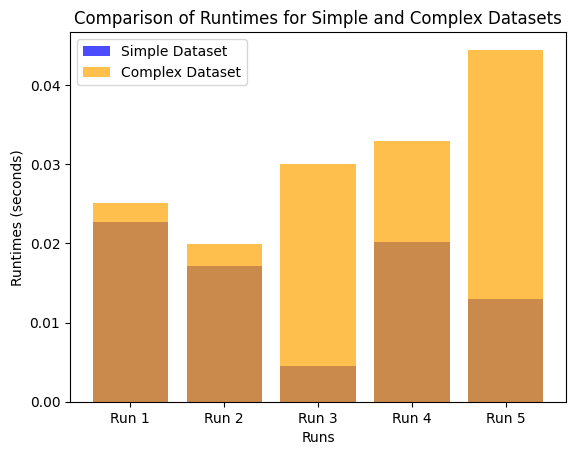

In [28]:
runtimes_simple = [0.02266, 0.01710, 0.00449, 0.02018, 0.01303]
runtimes_complex = [0.02509, 0.01986, 0.03008, 0.03290, 0.04445]

labels = ["Run 1", "Run 2", "Run 3", "Run 4", "Run 5"]

plt.bar(labels, runtimes_simple, label='Simple Dataset', color='blue', alpha=0.7)
plt.bar(labels, runtimes_complex, label='Complex Dataset', color='orange', alpha=0.7)

plt.xlabel("Runs")
plt.ylabel("Runtimes (seconds)")
plt.title("Comparison of Runtimes for Simple and Complex Datasets")
plt.legend()
plt.show()

The complexity of the dataset can have a substantial impact on the algorithm's runtime in several ways:

More complex datasets often correspond to larger solution spaces. As the algorithm searches for optimal solutions, a larger solution space can lead to increased computational effort and longer runtimes.

Complex datasets may exhibit irregular fitness landscapes. Navigating such landscapes can be more challenging for the algorithm, requiring additional evaluations and potentially increasing the runtime.


The algorithm's ability to converge to an optimal solution is influenced by the complexity of the dataset. In more complex datasets, the algorithm may take longer to identify and converge to high-quality solutions, leading to extended runtimes.

The complexity of the dataset can affect the genetic diversity within the population. If the dataset is complex and exhibits diverse patterns, maintaining diversity in the population becomes crucial. Achieving and preserving diversity might require more generations and, consequently, result in longer runtimes.